## Connect with Drive

In [0]:
from google.colab import drive
drive.mount("/betogaona7")

In [0]:
%cd ./../betogaona7/My\ Drive/app/Distracted

## Imports 

In [0]:
import os 
import random
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


In [0]:
%cd ./../..

## Create a TFRecord file

In [0]:
def imgs_with_labels(src):
  data = []
  total = 0
  for path, subdir, files in os.walk(src):
    for file in files:
      if file[-3:] == 'jpg': 
        data.append((os.path.join(path, file), path[-1:]))
      total += 1
  return data, total

data, total = imgs_with_labels("./data/train/")

In [42]:
img_path, label = data[random.randint(0, total)]
print("img: ", img_path, " label: ", label, " total: ", total )

img:  ./data/train/c7/img_34589.jpg  label:  7  total:  22424


In [0]:
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfr_name = "train.tfrecord"
writer = tf.python_io.TFRecordWriter(tfr_name)

for img_path, img_class in data:
  img = np.array(Image.open(img_path))
  
  img_raw = open(img_path, 'rb').read()
  label = int(img_class)
  path = str.encode(img_path)
  
  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(img_raw),
      'label': _int64_feature(label),
      'height': _int64_feature(img.shape[0]),
      'width': _int64_feature(img.shape[1]),
      'depth': _int64_feature(img.shape[2]),
      'path': _bytes_feature(path) }))
  writer.write(example.SerializeToString())
writer.close()

In [0]:
for example in tf.python_io.tf_record_iterator("train.tfrecord"):
  result = tf.train.Example.FromString(example)
print(result)

In [89]:
!du -lh train.tfrecord
!du -sh ./data/train/

911M	train.tfrecord
913M	./data/train/


## Build dataset 

In [0]:
def StateFarmDataset(image_size, tfrecord_file, shuffle_buffer_size):
  img_size = tf.cast(image_size, tf.int32)
  
  def _parse_function(example):
    features = {'label': tf.FixedLenFeature((), tf.int64),
                'image': tf.FixedLenFeature((), tf.string),
                'height': tf.FixedLenFeature((), tf.int64),
                'width': tf.FixedLenFeature((), tf.int64),
                'depth': tf.FixedLenFeature((), tf.int64),
                'path': tf.FixedLenFeature((), tf.string)}
    parsed_features = tf.parse_single_example(example, features)
    
    #image = tf.decode_raw(parsed_features['image'], tf.uint8)
    
    image = tf.image.decode_jpeg(parsed_features['image'], 3)
    img_shape = tf.stack([tf.cast(parsed_features['height'], tf.int32),
                          tf.cast(parsed_features['width'], tf.int32),
                          tf.cast(parsed_features['depth'], tf.int32)])
    
    image = tf.reshape(image, img_shape)
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.image.resize(image, [image_size, image_size])
    return image, parsed_features['label'], parsed_features['path']
  
  dataset = tf.data.TFRecordDataset(tfrecord_file)
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.map(_parse_function)
  
  return dataset         

In [78]:
train_data = StateFarmDataset(224, "train.tfrecord", total)
print(train_data)

<DatasetV1Adapter shapes: ((?, ?, ?), (), ()), types: (tf.float32, tf.int64, tf.string)>


Label:  1
Img path:  b'./data/train/c1/img_98368.jpg'
Img shape:  (480, 640, 3)


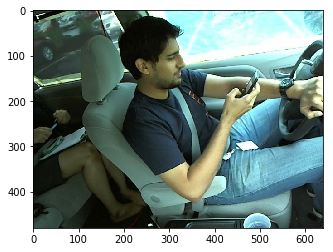

In [88]:
iterator = train_data.make_one_shot_iterator()
record = iterator.get_next()
with tf.Session() as sess:
  img, label, img_path = sess.run(record)
  print("Label: ", label)
  print("Img path: ", img_path)
  print("Img shape: ", img.shape)
  plt.imshow(img)